# Interactive 3D Visualization - Norne Partitions (Plotly)

In [1]:
# !pip install plotly

In [2]:
import torch
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from pathlib import Path

In [3]:
# Configuration
dataset_dir = Path("../dataset/Norne/NORNE_ATW2013_LHS.sim.dataset/XMGN_Norne")
case_name = "NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0000"
timestep = 2

In [4]:
# Load partition assignments
partition_json = dataset_dir / f"{case_name}_partitions.json"
with open(partition_json, 'r') as f:
    partition_info = json.load(f)

# Load raw graph
graph_file = dataset_dir / "graphs" / f"{case_name}_{timestep:03d}.pt"
graph = torch.load(graph_file, weights_only=False)

# Load partitioned graph
partitions_file = None
for split in ['train', 'val', 'test']:
    candidate = dataset_dir / "partitions" / split / f"partitions_{case_name}_{timestep:03d}.pt"
    if candidate.exists():
        partitions_file = candidate
        data_split = split
        break

if partitions_file is None:
    raise FileNotFoundError(f"Could not find partitioned graph for {case_name} timestep {timestep}")

partitions = torch.load(partitions_file, weights_only=False)

print(f"✓ Loaded data for {case_name}, timestep {timestep}")
print(f"  - Data split: {data_split}")
print(f"  - Number of partitions: {len(partitions)}")
print(f"  - Total nodes: {graph.num_nodes}")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Loaded data for NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0000, timestep 2
  - Data split: train
  - Number of partitions: 3
  - Total nodes: 44431


## Extract Coordinates and Partition Info

In [5]:
# Get coordinates
if hasattr(graph, 'coordinates'):
    coords = graph.coordinates.numpy()
else:
    coords = graph.x[:, 2:5].numpy()  # X, Y, Z

X, Y, Z = coords[:, 0], coords[:, 1], coords[:, 2]

# Get grid dimensions
nx = graph.grid_info['nx']
ny = graph.grid_info['ny']
nz = graph.grid_info['nz']

# Get partition assignments
partition_assignment = np.array(partition_info['partition_assignment'])
num_partitions = partition_info['num_partitions']

print(f"Grid dimensions: {nx} × {ny} × {nz}")
print(f"Active cells: {graph.num_nodes}")
print(f"Number of partitions: {num_partitions}")

Grid dimensions: 46 × 112 × 22
Active cells: 44431
Number of partitions: 3


## Identify Inner and Halo Nodes

In [6]:
# Build halo information
partition_array = np.copy(partition_assignment)
halo_array = np.zeros(graph.num_nodes, dtype=int)

halo_info = {}
for part_idx, partition in enumerate(partitions):
    part_id = part_idx + 1
    
    part_nodes = partition.part_node.numpy()
    inner_nodes_local = partition.inner_node.numpy()
    inner_nodes_global = part_nodes[inner_nodes_local]
    
    halo_mask_local = np.ones(len(part_nodes), dtype=bool)
    halo_mask_local[inner_nodes_local] = False
    halo_nodes_global = part_nodes[halo_mask_local]
    
    halo_info[part_id] = {
        'inner': inner_nodes_global,
        'halo': halo_nodes_global,
        'all': part_nodes
    }
    
    halo_array[halo_nodes_global] = part_id
    
    print(f"Partition {part_id}: {len(inner_nodes_global)} inner, {len(halo_nodes_global)} halo")

print(f"\n✓ Identified inner and halo nodes for {num_partitions} partitions")

Partition 1: 14940 inner, 9586 halo
Partition 2: 14928 inner, 9478 halo
Partition 3: 14563 inner, 13001 halo

✓ Identified inner and halo nodes for 3 partitions


## Visualization 1: Partition Assignments (Interactive 3D)

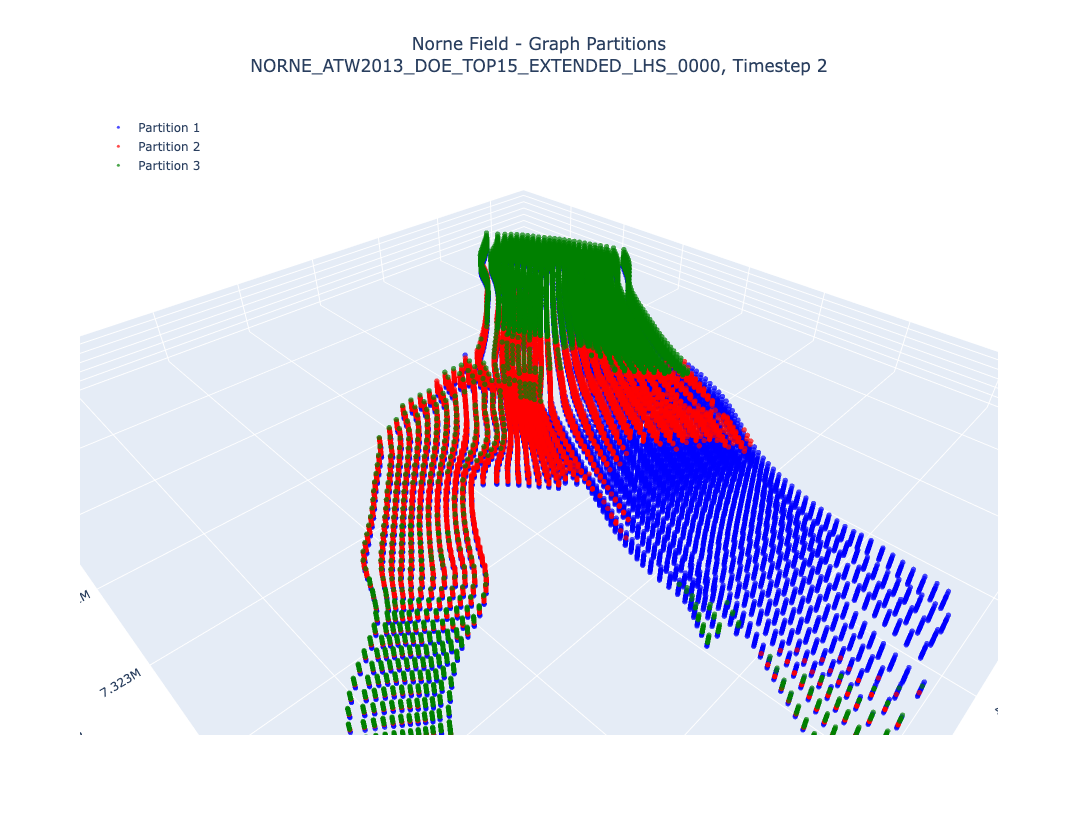

In [7]:
# Color map for partitions
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

# Create figure
fig = go.Figure()

# Add each partition as a separate trace
for part_idx in range(1, num_partitions + 1):
    mask = partition_array == part_idx
    if mask.sum() > 0:
        fig.add_trace(go.Scatter3d(
            x=X[mask],
            y=Y[mask],
            z=Z[mask],
            mode='markers',
            name=f'Partition {part_idx}',
            marker=dict(
                size=3,
                color=colors[(part_idx - 1) % len(colors)],
                opacity=0.7
            )
        ))

# Update layout
fig.update_layout(
    title=dict(
        text=f'Norne Field - Graph Partitions<br>{case_name}, Timestep {timestep}',
        x=0.5,
        xanchor='center'
    ),
    scene=dict(
        xaxis_title='X [m]',
        yaxis_title='Y [m]',
        zaxis_title='Z [m]',
        aspectmode='data'
    ),
    width=1200,
    height=800,
    showlegend=True,
    legend=dict(x=0.02, y=0.98)
)

fig.show()

## Visualization 2: Halo Regions Highlighted

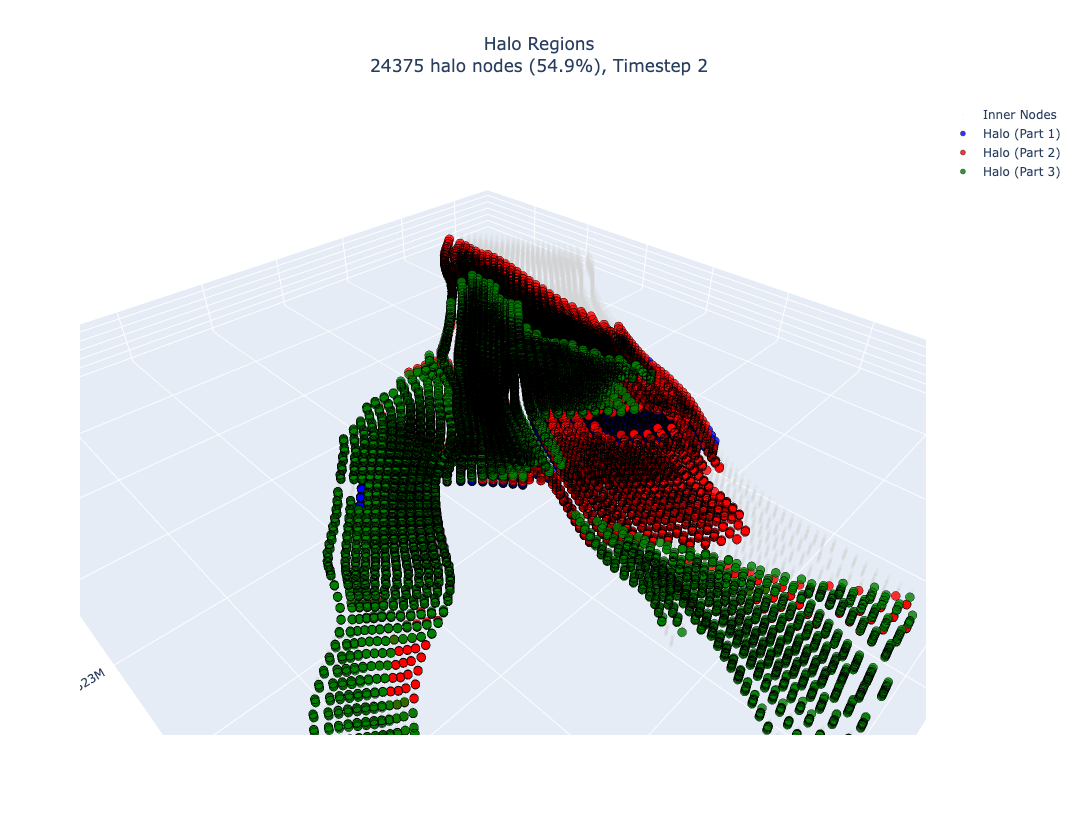

In [8]:
# Create figure
fig = go.Figure()

# Add inner nodes (gray, small, transparent)
inner_mask = (partition_array > 0) & (halo_array == 0)
if inner_mask.sum() > 0:
    fig.add_trace(go.Scatter3d(
        x=X[inner_mask],
        y=Y[inner_mask],
        z=Z[inner_mask],
        mode='markers',
        name='Inner Nodes',
        marker=dict(
            size=2,
            color='lightgray',
            opacity=0.2
        )
    ))

# Add halo nodes (colored by partition, larger)
for part_idx in range(1, num_partitions + 1):
    halo_mask = halo_array == part_idx
    if halo_mask.sum() > 0:
        fig.add_trace(go.Scatter3d(
            x=X[halo_mask],
            y=Y[halo_mask],
            z=Z[halo_mask],
            mode='markers',
            name=f'Halo (Part {part_idx})',
            marker=dict(
                size=5,
                color=colors[(part_idx - 1) % len(colors)],
                opacity=0.8,
                line=dict(color='black', width=0.5)
            )
        ))

total_halo = (halo_array > 0).sum()
halo_percent = 100 * total_halo / graph.num_nodes

fig.update_layout(
    title=dict(
        text=f'Halo Regions<br>{total_halo} halo nodes ({halo_percent:.1f}%), Timestep {timestep}',
        x=0.5,
        xanchor='center'
    ),
    scene=dict(
        xaxis_title='X [m]',
        yaxis_title='Y [m]',
        zaxis_title='Z [m]',
        aspectmode='data'
    ),
    width=1200,
    height=800,
    showlegend=True
)

fig.show()

## Visualization 3: Individual Partitions with Halo

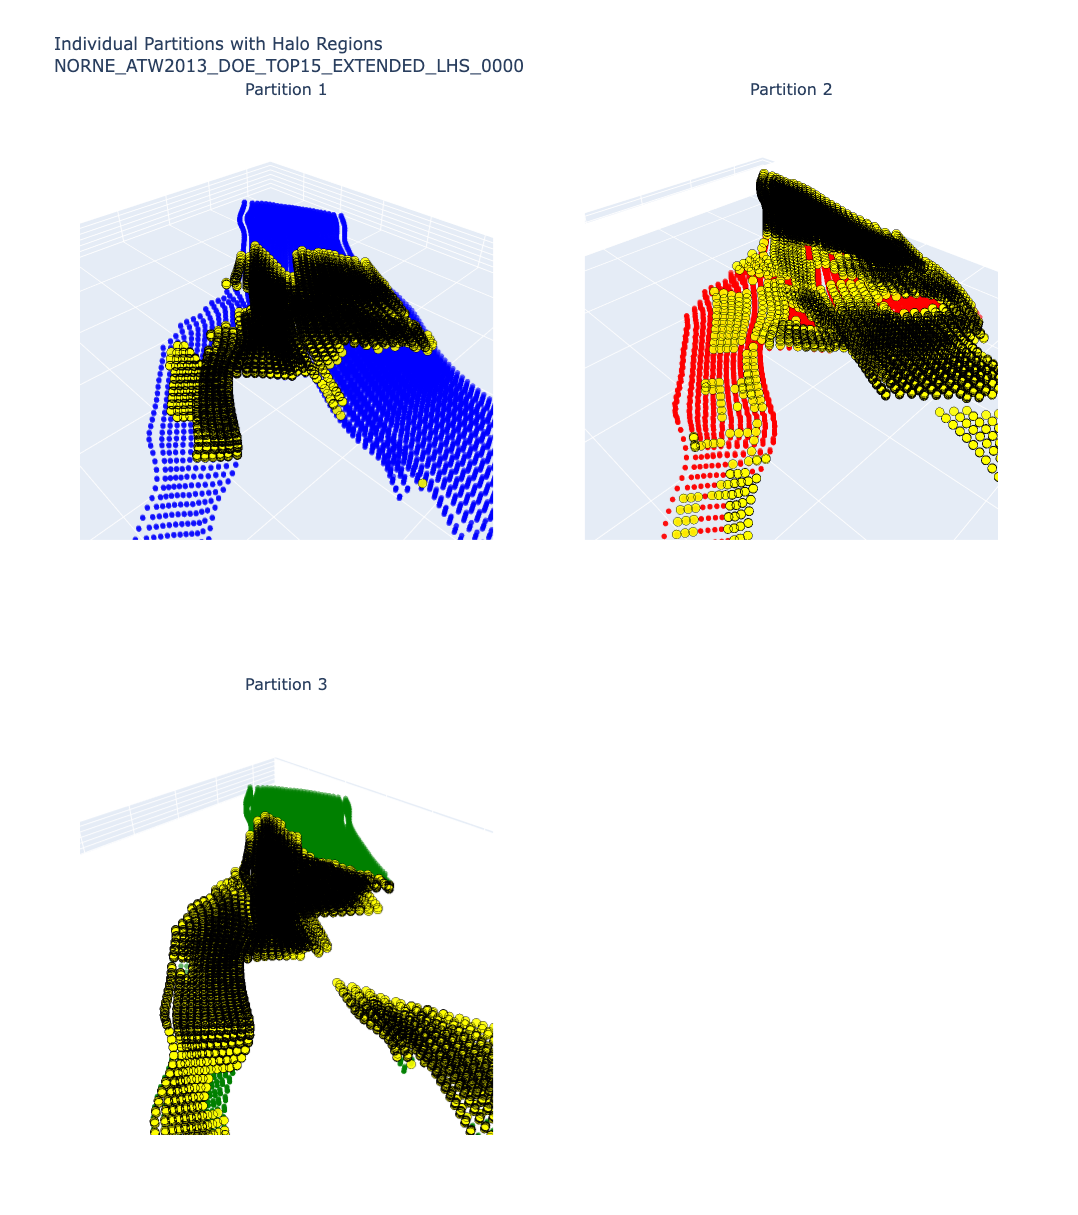

In [9]:
# Create subplot layout
n_rows = (num_partitions + 1) // 2
n_cols = 2

specs = [[{'type': 'scatter3d'} for _ in range(n_cols)] for _ in range(n_rows)]
subplot_titles = [f'Partition {i+1}' for i in range(num_partitions)]

fig = make_subplots(
    rows=n_rows, 
    cols=n_cols,
    specs=specs,
    subplot_titles=subplot_titles,
    vertical_spacing=0.15,
    horizontal_spacing=0.1
)

for part_idx in range(1, num_partitions + 1):
    row = (part_idx - 1) // 2 + 1
    col = (part_idx - 1) % 2 + 1
    
    inner_nodes = halo_info[part_idx]['inner']
    halo_nodes = halo_info[part_idx]['halo']
    
    # Add inner nodes
    if len(inner_nodes) > 0:
        fig.add_trace(
            go.Scatter3d(
                x=X[inner_nodes],
                y=Y[inner_nodes],
                z=Z[inner_nodes],
                mode='markers',
                name=f'P{part_idx} Inner',
                marker=dict(
                    size=3,
                    color=colors[(part_idx - 1) % len(colors)],
                    opacity=0.6
                ),
                showlegend=False
            ),
            row=row, col=col
        )
    
    # Add halo nodes
    if len(halo_nodes) > 0:
        fig.add_trace(
            go.Scatter3d(
                x=X[halo_nodes],
                y=Y[halo_nodes],
                z=Z[halo_nodes],
                mode='markers',
                name=f'P{part_idx} Halo',
                marker=dict(
                    size=5,
                    color='yellow',
                    opacity=0.9,
                    line=dict(color='black', width=1)
                ),
                showlegend=False
            ),
            row=row, col=col
        )

# Update layout
fig.update_layout(
    title_text=f'Individual Partitions with Halo Regions<br>{case_name}',
    height=600 * n_rows,
    width=1400,
    showlegend=False
)

# Update all 3D scene properties
for i in range(1, num_partitions + 1):
    scene_name = f'scene{i}' if i > 1 else 'scene'
    fig.update_layout({
        scene_name: dict(
            aspectmode='data',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    })

fig.show()

## Export Interactive HTML

Save the visualizations as interactive HTML files that can be opened in any browser.

In [10]:
# Create output directory
output_dir = Path("visualization_outputs")
output_dir.mkdir(exist_ok=True)

# ===== Export 1: Partition View =====
fig_partition = go.Figure()
for part_idx in range(1, num_partitions + 1):
    mask = partition_array == part_idx
    if mask.sum() > 0:
        fig_partition.add_trace(go.Scatter3d(
            x=X[mask], y=Y[mask], z=Z[mask],
            mode='markers',
            name=f'Partition {part_idx}',
            marker=dict(size=3, color=colors[(part_idx - 1) % len(colors)], opacity=0.7)
        ))

fig_partition.update_layout(
    title=f'Norne Field - Graph Partitions<br>{case_name}, Timestep {timestep}',
    scene=dict(xaxis_title='X [m]', yaxis_title='Y [m]', zaxis_title='Z [m]', aspectmode='data'),
    width=1200, height=800
)

html_file_partition = output_dir / f'{case_name}_partitions_t{timestep}.html'
fig_partition.write_html(html_file_partition)
print(f"✓ Saved partition view to {html_file_partition}")

# ===== Export 2: Halo Regions View =====
fig_halo = go.Figure()

# Add inner nodes (gray, small, transparent)
inner_mask = (partition_array > 0) & (halo_array == 0)
if inner_mask.sum() > 0:
    fig_halo.add_trace(go.Scatter3d(
        x=X[inner_mask],
        y=Y[inner_mask],
        z=Z[inner_mask],
        mode='markers',
        name='Inner Nodes',
        marker=dict(
            size=2,
            color='lightgray',
            opacity=0.2
        )
    ))

# Add halo nodes (colored by partition, larger)
for part_idx in range(1, num_partitions + 1):
    halo_mask = halo_array == part_idx
    if halo_mask.sum() > 0:
        fig_halo.add_trace(go.Scatter3d(
            x=X[halo_mask],
            y=Y[halo_mask],
            z=Z[halo_mask],
            mode='markers',
            name=f'Halo (Part {part_idx})',
            marker=dict(
                size=5,
                color=colors[(part_idx - 1) % len(colors)],
                opacity=0.8,
                line=dict(color='black', width=0.5)
            )
        ))

total_halo = (halo_array > 0).sum()
halo_percent = 100 * total_halo / graph.num_nodes

fig_halo.update_layout(
    title=f'Norne Field - Halo Regions<br>{case_name}, Timestep {timestep}<br>{total_halo} halo nodes ({halo_percent:.1f}%)',
    scene=dict(xaxis_title='X [m]', yaxis_title='Y [m]', zaxis_title='Z [m]', aspectmode='data'),
    width=1200, height=800,
    showlegend=True
)

html_file_halo = output_dir / f'{case_name}_halo_regions_t{timestep}.html'
fig_halo.write_html(html_file_halo)
print(f"✓ Saved halo regions view to {html_file_halo}")

print(f"\n Output directory: {output_dir.absolute()}")
print(f"\n Open in browser:")
print(f"   - Partitions: file://{html_file_partition.absolute()}")
print(f"   - Halo Regions: file://{html_file_halo.absolute()}")

✓ Saved partition view to visualization_outputs/NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0000_partitions_t2.html
✓ Saved halo regions view to visualization_outputs/NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0000_halo_regions_t2.html

 Output directory: /workspace/examples/reservoir_simulation/xmgn/visualization_outputs

 Open in browser:
   - Partitions: file:///workspace/examples/reservoir_simulation/xmgn/visualization_outputs/NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0000_partitions_t2.html
   - Halo Regions: file:///workspace/examples/reservoir_simulation/xmgn/visualization_outputs/NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0000_halo_regions_t2.html


## Summary Statistics

In [10]:
print("="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"Case: {case_name}")
print(f"Timestep: {timestep}")
print(f"Grid dimensions: {nx} × {ny} × {nz} = {nx * ny * nz} cells")
print(f"Active cells: {graph.num_nodes}")
print(f"Number of partitions: {num_partitions}")
print()

for part_idx in range(1, num_partitions + 1):
    inner_count = (partition_array == part_idx).sum()
    halo_count = (halo_array == part_idx).sum()
    total_count = inner_count + halo_count
    print(f"Partition {part_idx}:")
    print(f"  - Inner nodes: {inner_count} ({100 * inner_count / graph.num_nodes:.2f}%)")
    print(f"  - Halo nodes: {halo_count}")
    print(f"  - Total nodes (with halo): {total_count}")
    if inner_count > 0:
        print(f"  - Halo overhead: {100 * halo_count / inner_count:.2f}%")
    print()

total_halo = (halo_array > 0).sum()
print(f"Total unique halo nodes: {total_halo} ({100 * total_halo / graph.num_nodes:.2f}%)")
print("="*70)

SUMMARY STATISTICS
Case: NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0000
Timestep: 2
Grid dimensions: 46 × 112 × 22 = 113344 cells
Active cells: 44431
Number of partitions: 3

Partition 1:
  - Inner nodes: 14940 (33.63%)
  - Halo nodes: 2708
  - Total nodes (with halo): 17648
  - Halo overhead: 18.13%

Partition 2:
  - Inner nodes: 14928 (33.60%)
  - Halo nodes: 8666
  - Total nodes (with halo): 23594
  - Halo overhead: 58.05%

Partition 3:
  - Inner nodes: 14563 (32.78%)
  - Halo nodes: 13001
  - Total nodes (with halo): 27564
  - Halo overhead: 89.27%

Total unique halo nodes: 24375 (54.86%)
